In [1]:
import gym 
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU 
import torch.nn.functional as F
from torch.autograd import Variable

This notebook use a vanilla Actor Critic Algorithm which is the exactly the same one on 
page 332, Reinforcement Learning by Sutton 2018 Edition. 

Thus, it is not A2C which uses Advantage and not Q-based method. It does not use Eligibility Trace as well.
Nevertheless, it is able to converge to stable optimal policy within around 1000 episodes.

Key Algorithm:

$\alpha_a$ for learning rate of actor, and $\alpha_c$ for learning rate of critic, 
former is controlled by optimizer and later is by manually added.

$I = 1$

Loop while not terminal:

$\quad A \sim \pi(\cdot|S,\theta)$

$\quad \delta = R + \gamma V(S',w) - V(S,w)$ ($V(S',w)$ = 0 if $S'$ is terminal)

$\quad w = w + \alpha_c \delta\, \nabla V(S,w)$

$\quad\theta = \theta + \alpha_a I \delta \nabla \ln \pi(A|S,\theta)$

$\quad I = \gamma I $

$\quad S = S'$

Difficulty:
Fine-tune.

In [2]:
class Actor(torch.nn.Module):
    def __init__(self):
        super(Actor,self).__init__()
        self.fc1 = Linear(4, 128)
        self.fc2 = Linear(128, 128)
        self.fc3 = Linear(128, 2)
        self.fc4 = Linear(128, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action = F.log_softmax(self.fc3(x), dim=-1)
        V = F.relu(self.fc4(x))
        return action, V

/home/lywanglab/anaconda3/envs/lab/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


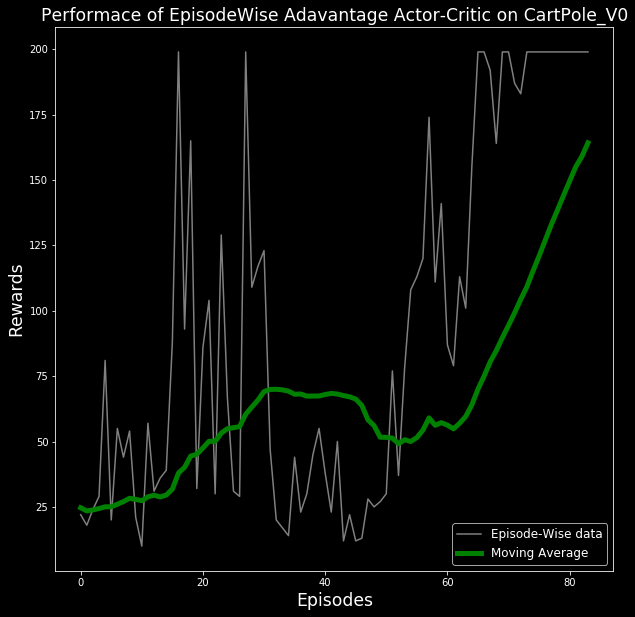

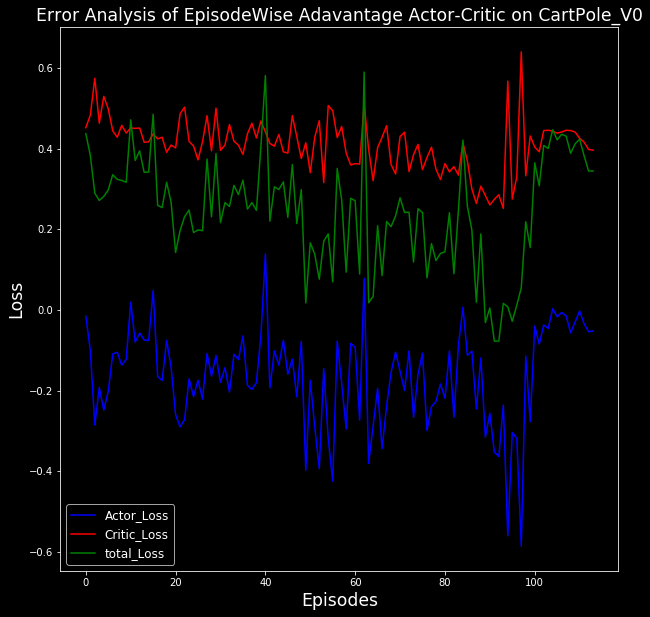

In [3]:
device = 'cpu'
# I do not recommend using GPU for this method. CPU is much faster.
# Change this to cuda only if you have a poor CPU or on a cloud
env = gym.make('CartPole-v0')
obs = env.reset()
actor = Actor()
actor.to(device)
optimizer_actor= torch.optim.Adam(actor.parameters(), lr=0.003)
gamma = 0.99
steps = []
A_loss = []
C_loss = []
eps = np.finfo(np.float32).eps.item()
for episode in range(1000):
    action_log_history = []
    V_history = []
    for step in range(200):
        #-----lines below are line-corresponding to the original algorithm----
        obs = np.reshape(obs, [1,-1])
        input_actor = Variable(torch.from_numpy(obs).float()).to(device)
        action_log_probability, V = actor(input_actor)
        p = np.exp(action_log_probability[0].detach().cpu())
        action = np.random.choice(2, p=p.numpy())  
        action_log_history.append(action_log_probability[0][action])
        V_history.append(V)
        obs, reward, done, info = env.step(action)
        if done:
            actor.zero_grad()
            steps.append(step)
            print(f'episode {episode}, step {step}', end='\r')
            obs = env.reset()
            reward_list = np.ones((step + 1,))
            for i in range(len(reward_list)-2, -1, -1):
                reward_list[i] += reward_list[i+1] * gamma
            reward_list -= np.mean(reward_list)
            reward_list /= (np.std(reward_list)+eps)
            Critic_Loss = 0
            Delta = []
            for monte_carlo_return , V in zip(reward_list, V_history):
                Critic_Loss += F.smooth_l1_loss(V, torch.tensor([monte_carlo_return]))
                Delta.append(monte_carlo_return - V.detach())
            Actor_Loss = 0
            for delta, log_prob in zip(Delta, action_log_history):
                Actor_Loss -= log_prob*delta.detach()
            A_loss.append(Actor_Loss.item()/step)
            C_loss.append(Critic_Loss.item()/step)
            loss = Critic_Loss + Actor_Loss
            loss.backward()
            optimizer_actor.step()
            break
    if np.mean(steps[-20:]) > 190:
        break   
mid = []
interval = 30
plt.style.use('dark_background')
for i in range(len(steps) - interval):
    mid.append(np.mean(steps[i:i+interval+1]))
plt.figure(figsize=(10,10))
plt.title('Performace of EpisodeWise Adavantage Actor-Critic on CartPole_V0',fontsize = 'xx-large')
plt.xlabel('Episodes', fontsize = 'xx-large')
plt.ylabel('Rewards',fontsize = 'xx-large')
x_fit = list(range(len(steps) - interval))
plt.plot(x_fit, steps[interval:], '-', c = 'gray', label='Episode-Wise data') 
plt.plot(mid, '-', c= 'green', linewidth = 5, label='Moving Average')
plt.legend(loc="best",prop={'size': 12})
plt.show()
plt.figure(figsize=(10,10))
plt.title('Error Analysis of EpisodeWise Adavantage Actor-Critic on CartPole_V0',fontsize = 'xx-large')
plt.xlabel('Episodes', fontsize = 'xx-large')
plt.ylabel('Loss',fontsize = 'xx-large')
T_loss = [sum(x) for x in zip(A_loss, C_loss)]
plt.plot(A_loss, c = 'blue', label = 'Actor_Loss')
plt.plot(C_loss, c = 'red', label = 'Critic_Loss')
plt.plot(T_loss, c = 'green', label = 'total_Loss')
plt.legend(loc="best",prop={'size': 12})
plt.show()